In [1220]:
import numpy as np
import pandas as pd
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
nlp = spacy.load('en')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [1221]:
df = pd.read_csv('us_companies.csv')
df.head(2)

,company_name_id,company_name,url,year_founded,city,state,country,zip_code,full_time_employees,company_type,...,business_model,social_impact,description,description_short,source_count,data_types,example_uses,data_impacts,financial_info,last_updated
0,3-round-stones-inc,"3 Round Stones, Inc.",http://3RoundStones.com,2010.0,Washington,DC,us,20004.0,10-Jan,Private,...,"Business to Business, Business to Consumer",NaN,3 Round Stones produces a platform for publish...,Our Open Source platform is used by the Fortun...,NaN,NaN,NaN,[],"3 Round Stones is a profitable, self-funded, w...",44:26.0
1,48-factoring-inc,48 Factoring Inc.,https://www.48factoring.com,2014.0,Philadelphia,PA,us,19087.0,51-200,Private,...,Business to Business,Small Business Owners,The company mission is to provide finance to s...,48 Factoring Inc. is one of the best financial...,Nov-50,Business,NaN,"[u'Cost efficiency', u'Job growth', u'Revenue ...",NaN,36:39.9


In [1222]:
df.columns

Index(['company_name_id', 'company_name', 'url', 'year_founded', 'city',
       'state', 'country', 'zip_code', 'full_time_employees', 'company_type',
       'company_category', 'revenue_source', 'business_model', 'social_impact',
       'description', 'description_short', 'source_count', 'data_types',
       'example_uses', 'data_impacts', 'financial_info', 'last_updated'],
      dtype='object')

#### Data Wrangling

In [1223]:
## cleanup empty and misspelled industry codes
df = df[df['company_category'].notnull()]
df.loc[df['company_category']=='Data/Technology,', 'company_category']='Data/Technology'
df.loc[df['company_category']=='Housing/Real Estate,', 'company_category']='Housing/Real Estate'
## removing industry codes that contain only 1 company
df = df[df['company_category']!='Aerospace and Defense']
print(df.company_category.unique())
print(df.company_category.nunique())

['Data/Technology' 'Finance & Investment' 'Research & Consulting'
 'Governance' 'Environment & Weather' 'Business & Legal Services'
 'Healthcare' 'Lifestyle & Consumer' 'Transportation' 'Insurance'
 'Education' 'Energy' 'Scientific Research' 'Geospatial/Mapping'
 'Housing/Real Estate' 'Food & Agriculture' 'Media']
17


In [1224]:
desc_ind = df[['description', 'company_category']]
print(desc_ind.shape)

(525, 2)


#### Text Pre-Processing

In [1225]:
## expanding contractions
import re
from contractions import CONTRACTION_MAP

def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [1226]:
## removing accented characters
import unicodedata
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

In [1227]:
## removing special characters
def remove_special_characters(text):
    text = re.sub('[^a-zA-Z0-9\s]', '', text)
    return text

In [1228]:
## lemmatizing text
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_!='-PRON-' else word.text for word in text])
    return text

In [1229]:
## removing stopwords:
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
#stopword_list.remove('no')
#stopword_list.remove('not')

def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

In [1230]:
## Normalize text corpus - altogether
def normalize_corpus(corpus, accented_char_removal=True, contraction_expansion=True, text_lower_case=True, text_lemmatization=True, 
                    special_char_removal=True, stopword_removal=True):
    normalized_corpus = []
    for doc in corpus:
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        if contraction_expansion:
            doc = expand_contractions(doc)
        if text_lower_case:
            doc = doc.lower()
        if text_lemmatization:
            doc = lemmatize_text(doc)
        if special_char_removal:
            doc = remove_special_characters(doc)
        ## remove extra white spaces
        doc = re.sub(' +', ' ', doc)
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
        
        normalized_corpus.append(doc)
    return normalized_corpus

In [1231]:
## Normalize company description
description = desc_ind['description']
normalized_description = normalize_corpus(description)
desc_ind['normalized_description'] = normalized_description
desc_ind.head()

,description,company_category,normalized_description
0,3 Round Stones produces a platform for publish...,Data/Technology,3 round stone produce platform publish datum w...
1,The company mission is to provide finance to s...,Finance & Investment,company mission provide finance small business...
2,"At 5PSolutions, we wish to make all basic info...",Data/Technology,5psolutions wish make basic information differ...
3,"Abt Associates is a mission-driven, internatio...",Research & Consulting,abt associate mission drive international comp...
4,Accela powers thousands of services and millio...,Governance,accela power thousand service million transact...


In [1232]:
## Group industry codes into 5 bigger groups
ind_code_dict = {'Data/Technology': 'Data/Technology', 'Finance & Investment': 'Business & Financial Services', 
                 'Research & Consulting': 'Business & Financial Services', 'Governance': 'Business & Financial Services',
                 'Environment & Weather': 'Business & Financial Services', 
                 'Business & Legal Services': 'Business & Financial Services', 'Healthcare': 'Healthcare', 
                 'Lifestyle & Consumer': 'Consumer Products & Services', 'Transportation': 'Consumer Products & Services',
                 'Insurance': 'Business & Financial Services', 'Education': 'Consumer Products & Services', 
                 'Energy': 'Energy', 'Scientific Research': 'Business & Financial Services',
                 'Geospatial/Mapping': 'Business & Financial Services', 'Housing/Real Estate': 'Business & Financial Services', 
                 'Food & Agriculture': 'Consumer Products & Services', 'Media': 'Consumer Products & Services'}

In [1233]:
desc_ind['industry_group'] = desc_ind['company_category'].map(ind_code_dict)
desc_ind.head()

,description,company_category,normalized_description,industry_group
0,3 Round Stones produces a platform for publish...,Data/Technology,3 round stone produce platform publish datum w...,Data/Technology
1,The company mission is to provide finance to s...,Finance & Investment,company mission provide finance small business...,Business & Financial Services
2,"At 5PSolutions, we wish to make all basic info...",Data/Technology,5psolutions wish make basic information differ...,Data/Technology
3,"Abt Associates is a mission-driven, internatio...",Research & Consulting,abt associate mission drive international comp...,Business & Financial Services
4,Accela powers thousands of services and millio...,Governance,accela power thousand service million transact...,Business & Financial Services


In [1234]:
desc_ind.industry_group.unique()

array(['Data/Technology', 'Business & Financial Services', 'Healthcare',
       'Consumer Products & Services', 'Energy'], dtype=object)

#### EDA

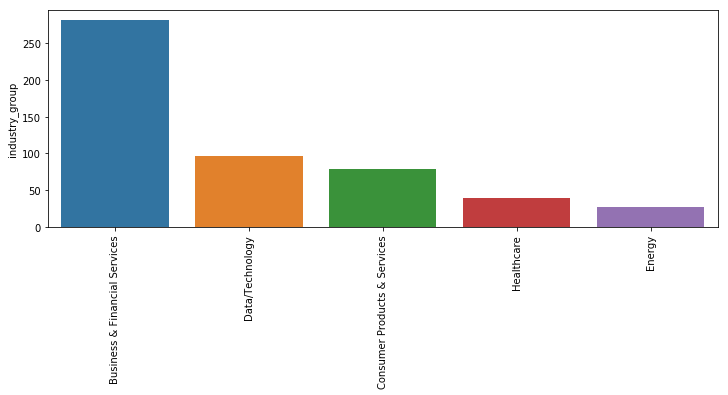

In [1235]:
## number of companies in each company_category
fig, ax = plt.subplots(figsize=(12,4))
co_in_cat = desc_ind.industry_group.value_counts()
_ = sns.barplot(x=co_in_cat.index, y=co_in_cat, ax=ax)
for i in _.get_xticklabels():
    i.set_rotation(90)

In [1236]:
co_in_cat

Business & Financial Services    281
Data/Technology                   97
Consumer Products & Services      79
Healthcare                        40
Energy                            28
Name: industry_group, dtype: int64

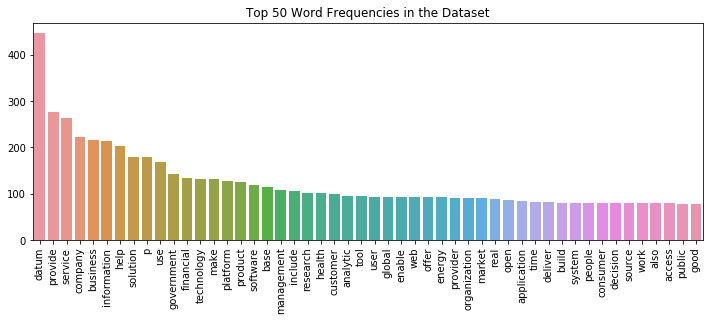

In [1237]:
## word counts
all_words = desc_ind.normalized_description.str.split(expand=True).unstack().value_counts()
fig, ax = plt.subplots(figsize=(12,4))
_ = sns.barplot(x=all_words.index[0:50], y=all_words[0:50], ax=ax)
plt.title('Top 50 Word Frequencies in the Dataset')
for i in _.get_xticklabels():
    i.set_rotation(90)

Text(0, 0.5, 'frequency')

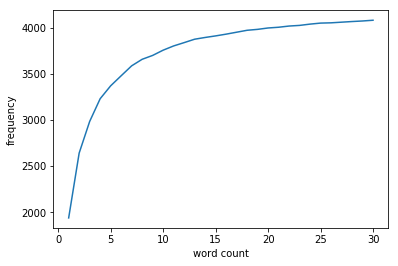

In [1238]:
word_count = all_words.value_counts().sort_index()
plt.plot(np.cumsum(word_count).head(30))
plt.xlabel('word count')
plt.ylabel('frequency')

We noticed that some of the words such as "company", "business", and "provide" etc. are common words to all companies. We will add these words to the stopword_list and remove those words from the analysis.

In [1239]:
stopword_list = nltk.corpus.stopwords.words('english')
newStopWords = ['company', 'business', 'provide', 'service', 'information', 'solution', 'use'
                , 'help', 'solution', 'include', 'technology', 'product', 'platform', 'offer', 'make'
                , 'user', 'customer']
stopword_list.extend(newStopWords)
print(len(stopword_list))

196


In [1240]:
new_normalized_description = desc_ind['normalized_description'].apply(lambda x: remove_stopwords(x, True))

In [1241]:
desc_ind['normalized_description'] = new_normalized_description
desc_ind.head()

,description,company_category,normalized_description,industry_group
0,3 Round Stones produces a platform for publish...,Data/Technology,3 round stone produce publish datum web 3 roun...,Data/Technology
1,The company mission is to provide finance to s...,Finance & Investment,mission finance small also financing small bad...,Business & Financial Services
2,"At 5PSolutions, we wish to make all basic info...",Data/Technology,5psolutions wish basic different category easi...,Data/Technology
3,"Abt Associates is a mission-driven, internatio...",Research & Consulting,abt associate mission drive international cond...,Business & Financial Services
4,Accela powers thousands of services and millio...,Governance,accela power thousand million transaction 500 ...,Business & Financial Services


In [1242]:
## word cloud for top 3 categories
data_tech = desc_ind[desc_ind['industry_group']=='Data/Technology']['normalized_description'].values
biz_fin = desc_ind[desc_ind['industry_group']=='Business & Financial Services']['normalized_description'].values
con = desc_ind[desc_ind['industry_group']=='Consumer Products & Services']['normalized_description'].values
energy = desc_ind[desc_ind['industry_group']=='Energy']['normalized_description'].values

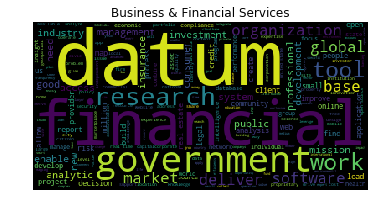

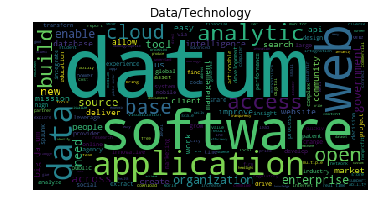

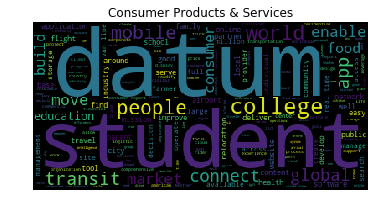

In [1243]:
from wordcloud import WordCloud, STOPWORDS
topic_list = {"Data/Technology": data_tech, "Business & Financial Services": biz_fin, 
              "Consumer Products & Services": con}

def generate_wordcloud(topic, title):
    wordcloud = WordCloud().generate(" ".join(topic))
    plt.imshow(wordcloud)#, interpolation='bilinear')
    plt.title(title)
    plt.axis("off")
    plt.show()

for key, value in topic_list.items():
    generate_wordcloud(value, key)

In [1244]:
# We can see that the companies in the Business & Financial Services sector often offer services on investment, credit, research, and financial and capital management. The Data & Technology sector focuses on datum(data), analytics, and web and software application. Business & Legal Services sector provides mostly legal help, risk management, and lawyer services.

#### Text Classification with Multinomial Naive Bayes

In [1245]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [1257]:
X = desc_ind['normalized_description']
y = desc_ind['industry_group']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [1258]:
cv = CountVectorizer()
#cv = CountVectorizer(min_df=2)
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

In [1259]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=12)
X_train_sm, y_train_sm = sm.fit_sample(X_train_cv, y_train)

#Count the number of occurences in the y_train sets to ensure that the oversampling worked 
from collections import Counter
class_check_woSMOTE = Counter(y_train)
class_check_words = Counter(y_train_sm)
print('class_check_woSMOTE: ', class_check_woSMOTE)
print('class_check_words: ', class_check_words)

class_check_woSMOTE:  Counter({'Business & Financial Services': 197, 'Data/Technology': 70, 'Consumer Products & Services': 55, 'Healthcare': 26, 'Energy': 19})
class_check_words:  Counter({'Business & Financial Services': 197, 'Healthcare': 197, 'Data/Technology': 197, 'Energy': 197, 'Consumer Products & Services': 197})


In [1260]:
clf = MultinomialNB()
clf.fit(X_train_sm, y_train_sm)
y_predict_train = clf.predict(X_train_sm)
y_predict = clf.predict(X_test_cv)
print('Accuracy on training set: ', metrics.accuracy_score(y_train_sm, y_predict_train))
print('Accuracy on test set: ', metrics.accuracy_score(y_test, y_predict))

Accuracy on training set:  0.9248730964467005
Accuracy on test set:  0.689873417721519


In [1261]:
y_test.value_counts()

Business & Financial Services    84
Data/Technology                  27
Consumer Products & Services     24
Healthcare                       14
Energy                            9
Name: industry_group, dtype: int64

In [1262]:
from sklearn.metrics import classification_report
#target_names = ['rotten', 'fresh']
print(classification_report(y_test, y_predict))

                               precision    recall  f1-score   support

Business & Financial Services       0.72      0.85      0.78        84
 Consumer Products & Services       0.61      0.46      0.52        24
              Data/Technology       0.44      0.41      0.42        27
                       Energy       1.00      0.67      0.80         9
                   Healthcare       0.91      0.71      0.80        14

                    micro avg       0.69      0.69      0.69       158
                    macro avg       0.74      0.62      0.67       158
                 weighted avg       0.69      0.69      0.68       158



158


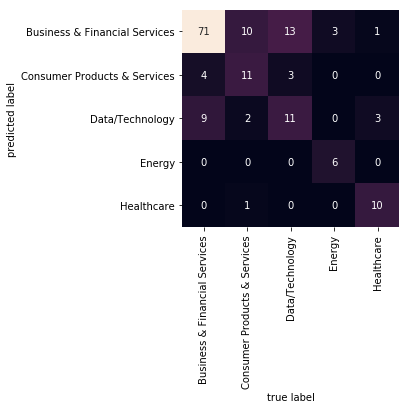

In [1263]:
mat = confusion_matrix(y_test, y_predict)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('true label')
plt.ylabel('predicted label')
print(len(y_test))

In [1264]:
test_df = pd.DataFrame(X_test)
test_df['y_test'] = y_test
test_df['y_predict'] = y_predict
diff = test_df[test_df['y_test']!=test_df['y_predict']]
diff.to_csv('diff.csv')

In [1265]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train_sm, y_train_sm)
y_predict_train = lr.predict(X_train_sm)
y_predict = lr.predict(X_test_cv)
print('Accuracy on training set: ', metrics.accuracy_score(y_train_sm, y_predict_train))
print('Accuracy on test set: ', metrics.accuracy_score(y_test, y_predict))

Accuracy on training set:  0.9807106598984772
Accuracy on test set:  0.6139240506329114


In [1266]:
from sklearn.svm import LinearSVC
svc = LinearSVC()
svc.fit(X_train_sm, y_train_sm)
y_predict_train = svc.predict(X_train_sm)
y_predict = svc.predict(X_test_cv)
print('Accuracy on training set: ', metrics.accuracy_score(y_train_sm, y_predict_train))
print('Accuracy on test set: ', metrics.accuracy_score(y_test, y_predict))

Accuracy on training set:  0.9827411167512691
Accuracy on test set:  0.5949367088607594


In [1267]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train_sm, y_train_sm)
y_predict_train = rf.predict(X_train_sm)
y_predict = rf.predict(X_test_cv)
print('Accuracy on training set: ', metrics.accuracy_score(y_train_sm, y_predict_train))
print('Accuracy on test set: ', metrics.accuracy_score(y_test, y_predict))

Accuracy on training set:  0.9796954314720813
Accuracy on test set:  0.46835443037974683
